Importación de las librerías

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

import cv2

import splitfolders
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Definimos la ruta de los datos de entrenamiento

In [2]:
ORIGINAL_PATH = 'train'

Debido a que el dataset estaba preparado para una competición de Kaggle, los datos de validación no están etiquetados, por lo tanto, tomaré solamente los datos de entrenamiento.

In [ ]:
splitfolders.ratio(ORIGINAL_PATH, output="Flowers-splitted", seed=42, ratio=(0.6, 0.2, 0.2))

Definimos un mapa donde están los labels de las diferentes clases de las flores existentes en el dataset

In [3]:
MAP_CHARACTERS = {
    0: 'daisy', 1: 'dandelion', 2: 'rose',
    3: 'sunflower', 4: 'tulip',
}

Inicializamos los párametros necesarios para el entrenamiento

In [4]:
IMG_SIZE = 128
LOTE_SIZE = 100

Método para cargar el dataset de entrenamiento

In [5]:
def load_train_set(dirname, map_characters, verbose=True):
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg") or file.endswith("png") 
                  or file.endswith("jpeg") or file.endswith("JPG") or file.endswith("webp")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

Método para cargar el dataset de test

In [6]:
def load_test_set(dirname, map_characters, verbose=True):
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg") or file.endswith("png") 
                  or file.endswith("jpeg") or file.endswith("JPG") or file.endswith("webp")]
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_test.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_test.append(label)
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)

Método para cargar el dataset de validación

In [7]:
def load_validation_set(dirname, map_characters, verbose=True):
    X_val = []
    y_val = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg") or file.endswith("png") 
                  or file.endswith("jpeg") or file.endswith("JPG") or file.endswith("webp")]
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_val.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_val.append(label)
    if verbose:
        print("Leídas {} imágenes de val".format(len(X_val)))
    return np.array(X_val), np.array(y_val)

Definimos ahora las 3 rutas de carpetas de entrenamiento, test y validación

In [8]:
DATASET_TRAIN_SPLITTED_PATH = 'Flowers-splitted/train'
DATASET_TEST_SPLITTED_PATH = 'Flowers-splitted/test'
DATASET_VAL_SPLITTED_PATH = 'Flowers-splitted/val'

Leemos las imágenes

In [9]:
X, y = load_train_set(DATASET_TRAIN_SPLITTED_PATH, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_SPLITTED_PATH, MAP_CHARACTERS)
X_v, y_v = load_validation_set(DATASET_VAL_SPLITTED_PATH, MAP_CHARACTERS)

Leyendo 300 imágenes encontradas de daisy
Leyendo 387 imágenes encontradas de dandelion
Leyendo 298 imágenes encontradas de rose
Leyendo 297 imágenes encontradas de sunflower
Leyendo 364 imágenes encontradas de tulip
Leídas 552 imágenes de test
Leídas 548 imágenes de val


Realiza aumento de datos para el entrenamiento. Utilizamos la clase ImageDataGenerator de Keras para aplicar transformaciones como rotación, desplazamiento, estiramiento, y volteo horizontal a imágenes.  Luego, flow_from_directory genera lotes de imágenes.

In [10]:
print("Realizando aumento de datos...")
image_gen_entrenamiento = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

#Generacion de datos de entrenamiento FTW
data_gen_entrenamiento = image_gen_entrenamiento.flow_from_directory(batch_size=LOTE_SIZE,
                                                     directory=DATASET_TRAIN_SPLITTED_PATH,
                                                     shuffle=True,
                                                     target_size=(IMG_SIZE,IMG_SIZE),
                                                     class_mode='categorical')

Realizando aumento de datos...
Found 1646 images belonging to 5 classes.


In [11]:
#Generacion de datos de validacion
image_gen_val = ImageDataGenerator(rescale=1./255)

data_gen_validacion = image_gen_val.flow_from_directory(batch_size=LOTE_SIZE,
                                                 directory=DATASET_VAL_SPLITTED_PATH,
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode='categorical')

Found 548 images belonging to 5 classes.


Aplicamos one-hot-encoding

In [12]:
y = tf.keras.utils.to_categorical(y, 5)
y_t = tf.keras.utils.to_categorical(y_t, 5)

Definimos el modelo de red neuronal, aplicando Dropout para evitar el sobreajuste. Hubo que realizar modificaciones para adaptarla a una salida de 5 clases diferentes.

In [13]:
modelo = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])


Compilamos el modelo

In [14]:
#Compilación
modelo.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Entrenamiento del modelo con 60 épocas

In [15]:
print("Entrenando modelo...");
epocas=60
history = modelo.fit_generator(
    data_gen_entrenamiento,
    steps_per_epoch=int(np.ceil(len(X) / float(LOTE_SIZE))),
    epochs=epocas,
    validation_data=data_gen_validacion,
    validation_steps=int(np.ceil(len(X_v) / float(LOTE_SIZE)))
)

print("Modelo entrenado!");

Entrenando modelo...


C:\Users\Aaron\AppData\Local\Temp\ipykernel_3096\3467653027.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelo.fit_generator(


Epoch 1/60



c:\Users\Aaron\anaconda3\Lib\site-packages\keras\src\backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



17/17 [==============================] - 31s 2s/step - loss: 1.5525 - accuracy: 0.2843 - val_loss: 1.3945 - val_accuracy: 0.3431
Epoch 2/60
17/17 [==============================] - 29s 2s/step - loss: 1.3041 - accuracy: 0.4101 - val_loss: 1.2999 - val_accuracy: 0.4380
Epoch 3/60
17/17 [==============================] - 30s 2s/step - loss: 1.2152 - accuracy: 0.4854 - val_loss: 1.2562 - val_accuracy: 0.5036
Epoch 4/60
17/17 [==============================] - 29s 2s/step - loss: 1.1681 - accuracy: 0.5194 - val_loss: 1.1928 - val_accuracy: 0.5146
Epoch 5/60
17/17 [==============================] - 29s 2s/step - loss: 1.0951 - accuracy: 0.5498 - val_loss: 1.0872 - val_accuracy: 0.5693
Epoch 6/60
17/17 [==============================] - 29s 2s/step - loss: 1.0376 - accuracy: 0.5765 - val_loss: 1.0602 - val_accuracy: 0.5730
Epoch 7/60
17/17 [==============================] - 28s 2s/step - loss: 0.9828 - accuracy: 0.6191 - val_loss: 0.9262 - val_accuracy: 0.6113
Epoch 8/60
17/17 [============

Guardamos el modelo para enviarlo a la aplicación web posteriormente

In [16]:
modelo.save('flowers.h5')

c:\Users\Aaron\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Mostramos las gráficas de precisión

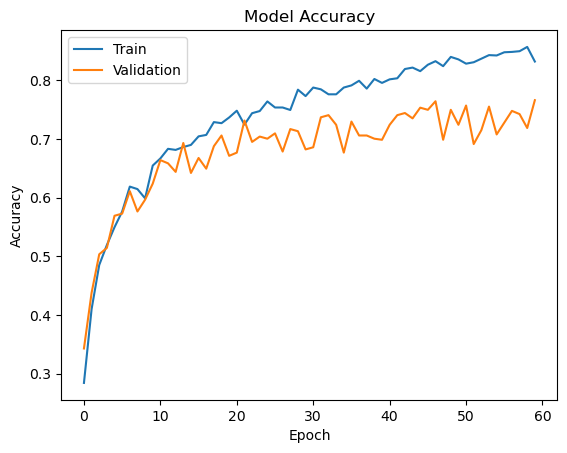

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Mostramos las gráficas de pérdida

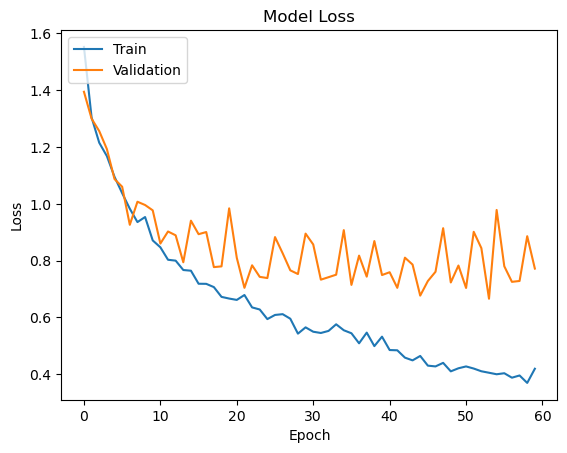

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [23]:
#Generacion de datos de validacion
image_gen_test = ImageDataGenerator(rescale=1./255)

data_gen_test = image_gen_test.flow_from_directory(batch_size=LOTE_SIZE,
                                                 directory=DATASET_TEST_SPLITTED_PATH,
                                                 target_size=(IMG_SIZE, IMG_SIZE),
                                                 class_mode='categorical')

X_test, y_test = data_gen_test.next()

Found 552 images belonging to 5 classes.


Realizamos una predicción

In [24]:
predictions = modelo.predict(X_test)

4/4 [==============================] - 0s 30ms/step


In [25]:
target_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

Mostramos el classification_report con los resultados de la predición

In [26]:
report = classification_report(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1), target_names=target_names)

print(report)

              precision    recall  f1-score   support

       daisy       0.90      0.86      0.88        22
   dandelion       0.94      0.70      0.80        23
        rose       0.73      0.65      0.69        17
   sunflower       0.72      1.00      0.84        21
       tulip       0.67      0.71      0.69        17

    accuracy                           0.79       100
   macro avg       0.79      0.78      0.78       100
weighted avg       0.81      0.79      0.79       100



Mostramos la matriz de confusión de la predicción del modelo

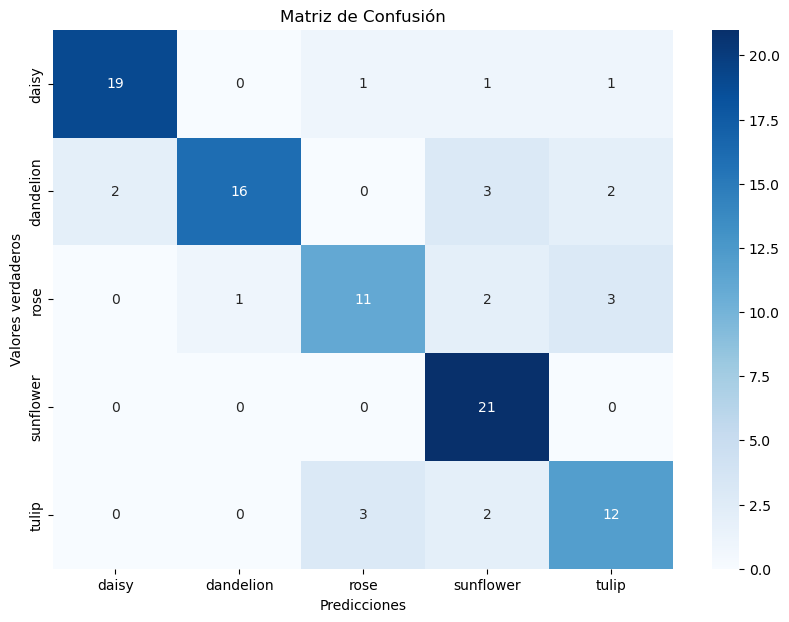

In [27]:
confusion_matrix_result = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix_result, annot=True, fmt='g', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicciones')
plt.ylabel('Valores verdaderos')
plt.title('Matriz de Confusión')
plt.show()